# Setup PATH to the model

In [1]:
PATH = 'sd_models_toyart/' #stable diffusion 1.5
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
vae = AutoencoderKL.from_pretrained(PATH , subfolder="vae", local_files_only=True)
tokenizer = CLIPTokenizer.from_pretrained(PATH, subfolder="tokenizer",local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(PATH, subfolder="text_encoder",local_files_only=True)
unet = UNet2DConditionModel.from_pretrained(PATH, subfolder="unet",local_files_only=True)
scheduler = UniPCMultistepScheduler.from_pretrained(PATH, subfolder="scheduler",local_files_only=True)


# setup cuda as default device

In [2]:

torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
num_inference_steps = 2  # Number of denoising steps
guidance_scale = 8.5  # Scale for classifier-free guidance

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 10.92 GiB total capacity; 1.32 GiB already allocated; 10.38 MiB free; 1.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# A function for generating multipl images
I should be using a pipe (??)

In [10]:
from PIL import Image
from tqdm.auto import tqdm
import random

def generate_images(prompt, tokenizer, text_encoder, unet, vae, scheduler, guidance_scale, n_samples, num_inference_steps):
    pil_images = []
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    torch_device = "cuda"
    seeds = [random.randint(1, 100) for _ in range(n_samples)]
    
    for seed in tqdm(seeds):
        generator = torch.manual_seed(seed)
        text_input = tokenizer(
            prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
        )

        with torch.no_grad():
            text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

        max_length = text_input.input_ids.shape[-1]
        uncond_input = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        latents = torch.randn(
            (1, unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            image = vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
  
        pil_image = Image.fromarray(image[0])
        #display(pil_image)
        pil_images.append(pil_image)
    
    return pil_images


  0%|          | 0/1 [00:00<?, ?it/s]

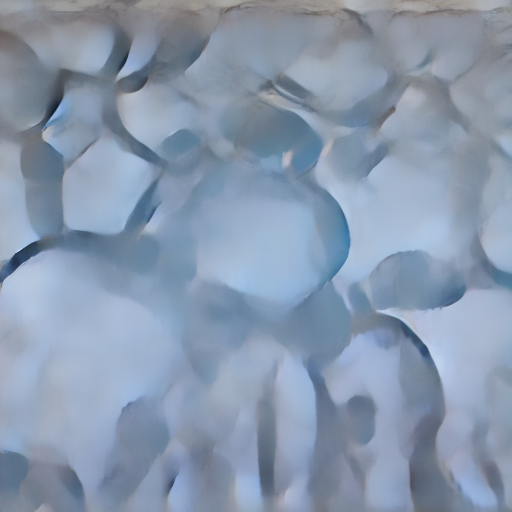

In [11]:
import random
prompt = ["an black and bright white acrilic more white with five very small characters with teeths and mouth open in the sky and big tree in the sks style"]
#prompt = ["a photo ultrarealistic the face of sks person [wearing ironman suit] from marvel movies, a detailed matte painting by Jeremy Geddes, cgsociety, space art, matte painting, redshift, concept art"]

#prompt = ["a drawing of a very  old person practicing bodyboarding on grass lawn character design pixiv"]
#prompt = ["a person bodyboarding on a grass GRASS  sled.fun,8k,insanely detailed,stunning environment, god rays"]

#prompt = ["a man  with the face of sks riding on the back of a white horse through a forest, a detailed matte painting by Jeremy Geddes, cgsociety, space art, matte painting, redshift, concept art"]
#seeds = [441, 414, 41411, 4417, 156,121] # or any other list of seeds you want to use
#seeds = [411414]
n_samples =1
images = generate_images(prompt, tokenizer, text_encoder, unet, vae, scheduler, guidance_scale, n_samples, num_inference_steps)
display(images[0])

In [13]:
%pip install gradio

Note: you may need to restart the kernel to use updated packages.


## A simple gradio interface

In [28]:
import gradio as gr
from PIL import Image

# Define the Gradio wrapper function
def gr_generate_images(prompt: str, num_images: int, num_inference: int):
    prompt = prompt + "sks style"
    images = generate_images(prompt, tokenizer, text_encoder, unet, vae, scheduler, guidance_scale, num_images, num_inference)
    return images

with gr.Blocks() as demo:
    with gr.Column(variant="panel"):
        with gr.Row(variant="compact"):
            text = gr.Textbox(
                label="Enter your prompt",
                show_label=False,
                max_lines=1,
                placeholder="a cute character",
            ).style(
                container=False,
            )
            btn = gr.Button("Generate image").style(full_width=False)
          
        with gr.Row(variant="compact"):
            num_images_slider = gr.Slider(
                minimum=1,
                maximum=10,
                step=1,
                default=1,
                label="Number of Images",
            )
   
            num_inference_steps_slider = gr.Slider(
                minimum=1,
                maximum=150,
                step=1,
                default=80,
                label="Number of Inference Steps",
            )
      
        gallery = gr.Gallery(
            label="Generated images", show_label=False, elem_id="gallery"
        ).style(columns=[5], rows=[1], object_fit="contain", height="200px", width="200px")

    btn.click(gr_generate_images, [text, num_images_slider,num_inference_steps_slider], gallery)

if __name__ == "__main__":
    demo.launch(share=True)



/opt/conda/lib/python3.10/site-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 1}
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 80}
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/components.py:167: UserWarning: Unknown style parameter: width
  warnings.warn(f"Unknown style parameter: {key}")


Running on local URL:  http://127.0.0.1:7877
Running on public URL: https://683411c9140f740ece.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


  0%|          | 0/1 [00:00<?, ?it/s]

/root/diffusers/src/diffusers/models/unet_2d_condition.py:452: FutureWarning: Accessing `in_channels` directly via unet.in_channels is deprecated. Please use `unet.config.in_channels` instead
  deprecate(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]